In [1]:
import os
import sys

In [2]:
repo_path = os.path.abspath(".")
sys.path.append(repo_path)

In [3]:
import copy
import datetime
import logging
import os
import time
from os.path import join

import pandas as pd
import torch
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import wandb
import numpy as np

from dataset import MetaLoader
from models.umt import UMT
from tasks.pretrain import setup_dataloaders
from tasks.retrieval_utils import evaluation_wrapper
from tasks.shared_utils import setup_model
from utils.basic_utils import MetricLogger, SmoothedValue, setup_seed
from utils.config import Config
from utils.config_utils import setup_main
from utils.distributed import get_rank, is_main_process
from utils.logger import log_dict_to_wandb, setup_wandb

/users/piyush/install/miniconda3/envs/vl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
from utils.config import Config
from configs.model import *

In [5]:
config = Config.from_file(filepath="./exp/zero_shot/ret_msrvtt/b16.py")

In [6]:
config

{'data_dir': 'your_data_path/anno',
 'data_root': 'your_data_path/anno/videos_images',
 'anno_root_pt': 'your_data_path/anno/anno_pretrain',
 'anno_root_downstream': 'your_data_path/anno/anno_downstream',
 'TextEncoders': {'bert': {'name': 'bert_base',
   'pretrained': 'bert-base-uncased',
   'config': 'configs/config_bert.json',
   'd_model': 768,
   'fusion_layer': 9},
  'bert_large': {'name': 'bert_large',
   'pretrained': 'bert-large-uncased',
   'config': 'configs/config_bert_large.json',
   'd_model': 1024,
   'fusion_layer': 19}},
 'train_file': ['your_data_path/anno/anno_downstream/msrvtt_ret_train9k.json',
  'your_msrvtt_path',
  'video'],
 'test_file': {'test': ['your_data_path/anno/anno_downstream/msrvtt_ret_test1k.json',
   'your_msrvtt_path',
   'video']},
 'test_types': ['test'],
 'num_workers': 6,
 'stop_key': 'test/',
 'is_paragraph_retrieval': False,
 'num_frames': 4,
 'num_frames_test': 4,
 'batch_size': 32,
 'max_txt_l': 32,
 'inputs': {'image_res': 224,
  'video_inp

In [8]:
# Setup path to pre-trained checkpoint
ckpt_root = "/work/piyush/pretrained_checkpoints/LargeModels/UnmaskedTeachers/"

config.pretrained_path = os.path.join(ckpt_root, "b16_25m.pth")
config.model.vision_encoder.pretrained = os.path.join(ckpt_root, "b16_ptk710_f8_res224.pth")

In [11]:
# Define the text encoder
config.model.text_encoder = TextEncoders["bert"]

# Define number of frames
config.model.vision_encoder.num_frames = config.num_frames

# Misc
config.distributed = False
config.scheduler.num_warmup_steps = 1
config.scheduler.num_training_steps = 1
config.auto_resume = False

In [12]:
setup_seed(config.seed + get_rank())
device = torch.device(config.device)
cudnn.benchmark = True

In [13]:
def num_params(model):
    n = np.sum([p.numel() for p in model.parameters()]) / 1e6
    print(f"Number of parameters in {type(model).__name__}: {np.round(n, 3)}M")

In [15]:
# Load model
model_cls = eval(config.model.get('model_cls', 'UMT'))
(
    model,
    model_without_ddp,
    optimizer,
    scheduler,
    scaler,
    tokenizer,
    start_epoch,
    global_step,
) = setup_model(
    config,
    model_cls=model_cls,
    has_decoder=False,
    pretrain=False,
    # find_unused_parameters=True,
    find_unused_parameters=False,
)

/users/piyush/install/miniconda3/envs/vl/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [16]:
num_params(model)

Number of parameters in UMT: 202.411M


### Data pipeline

In [21]:
from dataset.video_utils import VIDEO_READER_FUNCS
from dataset.utils import pre_text

In [23]:
sample_video = "../../TimeBound.v1/sample_data/folding_paper.mp4"
sample_texts = ["someone is folding a paper"]

# Preprocess text
sample_texts = [pre_text(t) for t in sample_texts]

In [41]:
config.inputs.video_input.num_frames_test = config.num_frames_test
num_frames = config.inputs.video_input.num_frames_test
sample_type = config.inputs.video_input.sample_type_test
video_reader_type = config.inputs.video_input.get("video_reader_type", "decord")

video_reader = VIDEO_READER_FUNCS[video_reader_type]

In [33]:
from torchvision import transforms
from torchvision.transforms import InterpolationMode

In [34]:
vision_enc_name = config.model.vision_encoder.name
if "swin" in vision_enc_name or "vit" in vision_enc_name:
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
elif "beit" in vision_enc_name:
    mean = (0.5, 0.5, 0.5)  # for all beit model except IN1K finetuning
    std = (0.5, 0.5, 0.5)
elif "clip" in vision_enc_name:
    mean = (0.48145466, 0.4578275, 0.40821073)
    std = (0.26862954, 0.26130258, 0.27577711)
else:
    raise ValueError

normalize = transforms.Normalize(mean, std)


# loaded images and videos are torch.Tensor of torch.uint8 format,
# ordered as (T, 1 or 3, H, W) where T=1 for image
type_transform = transforms.Lambda(lambda x: x.float().div(255.0))

if config.inputs.video_input.random_aug:
    aug_transform = transforms.RandAugment()
else:
    aug_transform = transforms.Lambda(lambda x: x)

test_transform = transforms.Compose(
    [
        transforms.Resize(
            (config.inputs.image_res, config.inputs.image_res),
            interpolation=InterpolationMode.BICUBIC,
        ),
        type_transform,
        normalize,
    ]
)

In [61]:
inv_transform = transforms.Normalize(
    mean=-(np.array(mean)/np.array(std)),
    std=1./np.array(std),
)

In [48]:
max_num_frames = -1
data_path = sample_video
frames, frame_indices, video_duration = video_reader(
    data_path, num_frames, sample_type, 
    max_num_frames=max_num_frames, client=None,
    trimmed30=False,
)

# shared aug for video frames
frames = test_transform(frames)

In [49]:
frames.shape, frame_indices

(torch.Size([4, 3, 224, 224]), [6, 19, 32, 45])

In [54]:
import matplotlib.pyplot as plt

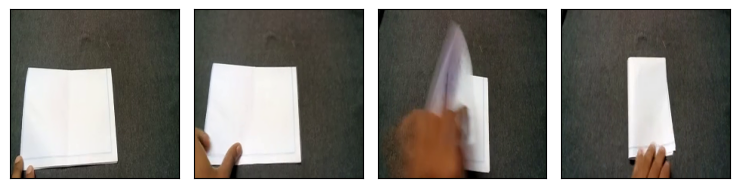

In [70]:
frames_show = [inv_transform(f).permute((1, 2, 0)) for f in frames]

fig, axes = plt.subplots(1, len(frames_show), figsize=(7.5, 2))
for i in range(len(axes)):
    ax = axes[i]
    ax.imshow(frames_show[i])
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

In [75]:
# Get text features

media_type = "video"
config.inputs.max_txt_l = {k: config.max_txt_l for k in config.inputs.max_txt_l}
max_txt_l = config.inputs.max_txt_l
max_txt_l = max_txt_l[media_type]
max_txt_l

32

In [77]:
from tasks.retrieval_utils import (
    extract_text_feats,
    extract_vision_feats,
)

In [82]:
text_feats, text_atts = extract_text_feats(
    sample_texts, max_txt_l, tokenizer, model, device
)  # (bsz, Lt, d), (bsz, Lt)

In [132]:
text_feats.shape

torch.Size([1, 32, 768])

In [83]:
.shape

torch.Size([4, 3, 224, 224])

In [85]:
image = frames.unsqueeze(0)
image = image.to(device, non_blocking=True)
image.shape

torch.Size([1, 4, 3, 224, 224])

In [113]:
image_feat, pooled_image_feat = model.encode_vision(image, test=True)
image_feat.shape, pooled_image_feat.shape

(torch.Size([1, 784, 768]), torch.Size([1, 4, 768]))

In [114]:
if config.evaluation.eval_frame_ensemble == "concat":  # default
    if len(image_feat.shape) == 4:
        image_feat = rearrange(image_feat, "b t l c -> b (t l) c").contiguous()
    image_feat = image_feat.unsqueeze(1)  # (bsz, 1, #frm*L, d)
else:
    assert config.video_input.num_frames == 1, "only support single-frame"
    assert config.evaluation.eval_frame_ensemble in ["mean", "max", "lse"]
# (bsz, 1, #frm*Li, d) or (bsz, #frm, Li, d), (bsz, #frm, d)
image_feat.shape, pooled_image_feat.shape

(torch.Size([1, 1, 784, 768]), torch.Size([1, 4, 768]))

In [121]:
pooled_image_feats = torch.cat([pooled_image_feat])
pooled_image_feats.shape

torch.Size([1, 4, 768])

In [125]:
from models.criterions import get_sim

In [126]:
_pooled_image_feats = (
    pooled_image_feats.to(device, non_blocking=True)
    if config.evaluation.eval_offload
    else pooled_image_feats
)

i2t_scores, t2i_scores = get_sim(
    model.vision_proj(_pooled_image_feats), model.text_proj(text_feats[:, 0])
)

In [127]:
i2t_scores.shape, t2i_scores.shape

(torch.Size([1, 1]), torch.Size([1, 1]))

In [131]:
t2i_scores.shape

torch.Size([1, 1])

In [128]:
i2t_scores

tensor([[0.4363]], device='cuda:0', grad_fn=<DivBackward0>)

In [123]:
_pooled_image_feats.shape

torch.Size([1, 4, 768])

In [100]:
image_feat.shape

torch.Size([1, 784, 768])

In [101]:
text_feats.shape

torch.Size([1, 32, 768])

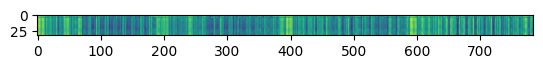

In [102]:
sim = (text_feats[0] @ image_feat[0].T).cpu().detach().float()
plt.imshow(sim)

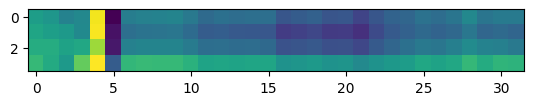

In [108]:
sim = (text_feats[0] @ pooled_image_feat[0].T).cpu().detach()
plt.imshow(sim.T)